Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 114, 114, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 114, 114, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 114, 114, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 114, 114, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 114, 114, 32)      0   

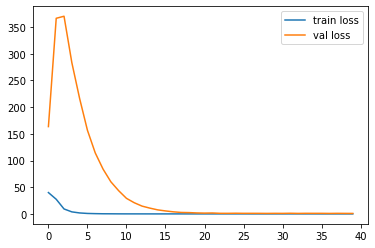

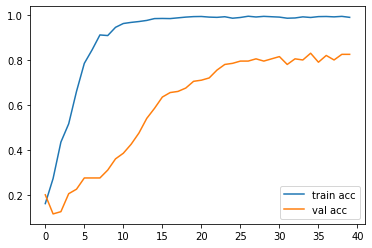

1/1 [==============================] - 1s 734ms/step - loss: 1.0828 - accuracy: 0.8300


[1.0828213691711426, 0.8299999833106995]

In [ ]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
 
 
IMAGE_SIZE = [227, 227]
 
model =MobileNet(input_shape= [227,227, 3], weights='imagenet', include_top=False)
"""
for layer in vgg.layers[:16]:
    layer.trainable = False
"""
for layer in model.layers[:-23]:
    layer.trainable = False
 
folders = glob('/content/drive/MyDrive/Colab Notebooks/Project/Sample1/training/*')
"""
layer_dict = dict([(layer.name, layer) for layer in model.layers])
 
conv_output = model.get_layer("block5_conv1").output  
 
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01),
                      name='block5_conv2')(conv_output)
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
 
x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=model.input, outputs=prediction)
"""
"""
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(model)
x = tf.keras.layers.Dropout(0.2)(x)
"""
x = Flatten()(model.layers[-6].output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs = model.input, outputs = prediction)
 
model.summary()
 
adam=tf.keras.optimizers.Adam(
        learning_rate=1e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        decay = 0.0
)
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)
#model.load_weights('/content/drive/MyDrive/Colab Notebooks/Project/sample/previews.data-00000-of-00001.hdf5')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #rescale = 1./255,
                                   rotation_range = 0,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Sample1/training',
                                                 target_size = (227, 227),
                                                 batch_size = 256,
                                                 class_mode = 'categorical',
                                                 )
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Sample1/testing',
                                            target_size = (227, 227),
                                            batch_size = 256,
                                            class_mode = 'categorical',
                                            )
 
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Project/sample/./weights.{epoch:02d}.hdf5'
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,mode = 'auto', restore_best_weights=True),
            tf.keras.callbacks.CSVLogger('traininglog.csv', separator=",", append=False),
            #tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=4, mode="auto",min_delta=0.0001,min_lr=1e-6),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True),
           ]
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks = [callback]
)
#Visualizing the results.
 
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
 
import tensorflow as tf
 
from keras.models import load_model
 
model.save('New_model.h5')
model.evaluate(test_set)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 114, 114, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 114, 114, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 114, 114, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 114, 114, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 114, 114, 32)      0   

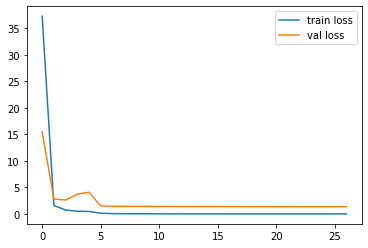

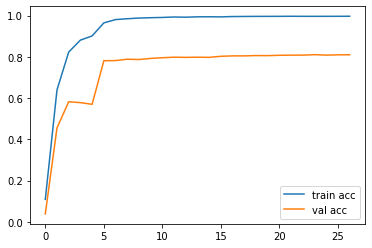

16/16 [==============================] - 11s 681ms/step - loss: 1.3738 - accuracy: 0.8100


[1.373832106590271, 0.8100000023841858]

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from keras.applications.mobilenet import MobileNet, preprocess_input
# import numpy as np
# from glob import glob
# import matplotlib.pyplot as plt
 
 
# IMAGE_SIZE = [227, 227]
 
# model =MobileNet(input_shape= [227,227, 3], weights='imagenet', include_top=False)
# """
# for layer in vgg.layers[:16]:
#     layer.trainable = False
# """
# for layer in model.layers[:-23]:
#     layer.trainable = False
 
# folders = glob('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/training/*')
# """
# layer_dict = dict([(layer.name, layer) for layer in model.layers])
 
# conv_output = model.get_layer("block5_conv1").output  
 
# x = layers.Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       kernel_regularizer=tf.keras.regularizers.l2(0.01),
#                       name='block5_conv2')(conv_output)
# x = layers.Conv2D(512, (3, 3),
#                       activation='relu',
#                       padding='same',
#                       name='block5_conv3')(x)
# x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
 
# x = Flatten()(x)
# prediction = Dense(len(folders), activation='softmax')(x)
# model = Model(inputs=model.input, outputs=prediction)
# """
# """
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# x = global_average_layer(model)
# x = tf.keras.layers.Dropout(0.2)(x)
# """
# x = Flatten()(model.layers[-6].output)
# prediction = Dense(len(folders), activation='softmax')(x)
# model = Model(inputs = model.input, outputs = prediction)
 
# model.summary()
 
# adam=tf.keras.optimizers.Adam(
#         learning_rate=1e-5,
#         beta_1=0.9,
#         beta_2=0.999,
#         epsilon=1e-07,
#         decay = 0.0
# )
# model.compile(
#   loss='categorical_crossentropy',
#   optimizer="adam",
#   metrics=['accuracy']
# )
# #model.load_weights('/content/drive/MyDrive/Colab Notebooks/Project/sample/previews.data-00000-of-00001.hdf5')
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    #rescale = 1./255,
#                                    rotation_range = 0,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/training',
#                                                  target_size = (227, 227),
#                                                  batch_size = 256,
#                                                  class_mode = 'categorical',
#                                                  shuffle=True)
# test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/testing',
#                                             target_size = (227, 227),
#                                             batch_size = 256,
#                                             class_mode = 'categorical',
#                                             shuffle=True)
 
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Project/sample/./weights.{epoch:02d}.hdf5'
# callback = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4,mode = 'auto', restore_best_weights=False),
#             tf.keras.callbacks.CSVLogger('traininglog.csv', separator=",", append=False),
#             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=2, mode="auto",min_delta=0.0001,min_lr=0),
#             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True),
#            ]
# r = model.fit(
#   training_set,
#   validation_data=test_set,
#   epochs=100,
#   steps_per_epoch=len(training_set),
#   validation_steps=len(test_set),
#   callbacks = [callback]
# )
# #Visualizing the results.
 
# plt.plot(r.history['loss'], label='train loss')
# plt.plot(r.history['val_loss'], label='val loss')
# plt.legend()
# plt.show()
# plt.plot(r.history['accuracy'], label='train acc')
# plt.plot(r.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()
 
# import tensorflow as tf
 
# from keras.models import load_model
 
# model.save('New_model.h5')
# model.save('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/New_model.h5')
# model.evaluate(test_set)

In [ ]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


IMAGE_SIZE = [227, 227]

model =MobileNet(input_shape= [227,227, 3], weights='imagenet', include_top=False)
"""
for layer in vgg.layers[:16]:
    layer.trainable = False
"""
for layer in model.layers[:-23]:
   layer.trainable = False

folders = glob('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/training/*')
"""
layer_dict = dict([(layer.name, layer) for layer in model.layers])

conv_output = model.get_layer("block5_conv1").output  

x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01),
                      name='block5_conv2')(conv_output)
x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

x = Flatten()(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=model.input, outputs=prediction)
"""
"""
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(model)
x = tf.keras.layers.Dropout(0.2)(x)
"""
x = Flatten()(model.layers[-6].output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs = model.input, outputs = prediction)

model.summary()

adam=tf.keras.optimizers.Adam(
        learning_rate=1e-5,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        decay = 0.0
)
model.compile(
  loss='categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)
#model.load_weights('/content/drive/MyDrive/Colab Notebooks/Project/sample/previews.data-00000-of-00001.hdf5')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #rescale = 1./255,
                                   rotation_range = 0,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/training',
                                                 target_size = (227, 227),
                                                 batch_size = 256,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/testing',
                                            target_size = (227, 227),
                                            batch_size = 256,
                                            class_mode = 'categorical',
                                            shuffle=True)

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Project/sample/./weights.{epoch:02d}.hdf5'
callback = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4,mode = 'auto', restore_best_weights=False),
            tf.keras.callbacks.CSVLogger('traininglog.csv', separator=",", append=False),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=2, mode="auto",min_delta=0.0001,min_lr=0),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True),
           ]
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks = [callback]
)
#Visualizing the results.

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

import tensorflow as tf
 
from keras.models import load_model
model.save('New_model.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/Project/Cars196/New_model_95_classes.h5')
model.evaluate(test_set)